In [1]:
# Run if working locally
%load_ext autoreload
%autoreload 2

In [102]:
import sqlite3
from sqlite3 import Error
import pickle
import os, sys
import config

config.root_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, config.root_path)

from src.dataset.dataset import RawData
from src.dataset.wikisection_preprocessing import (
    tokenize,
    clean_sentence,
    preprocess_text_segmentation,
    format_data_for_db_insertion,
)

from src.dataset.utils import truncate_by_token, flatten, dedupe_list, truncate_string
from src.bertkeywords.src.similarities import Embedding, Similarities
from src.bertkeywords.src.keywords import Keywords, Keyword
from src.coherencegraph.coherence_graph import CoherenceNode, CoherenceGraph
from db.dbv2 import Table, AugmentedTable, TrainTestTable
import pprint


from utils.metrics import windowdiff, pk
import networkx as nx
import torch

In [177]:
dataset_type = "city"
table = Table(dataset_type)

num_sentences = 10
offset = 100
max_segment_length = 100

all_segments = table.get_all_segments()

segments = [[y[1] for y in x][:max_segment_length] for x in all_segments]
segments_labels = [
    [1 if i == 0 else 0 for i, y in enumerate(x)][:max_segment_length] for x in all_segments
]

flattened_segments = flatten(segments)
flattened_labels = flatten(segments_labels)

segments_to_test = flattened_segments[offset:offset+num_sentences]
labels_to_test = flattened_labels[offset:offset+num_sentences]

Using dataset: wikisection_city


In [178]:
G = CoherenceGraph()

### Keywords

In [204]:
model_string="bert-base-uncased"

similarities_lib = Similarities(model_string)
keywords_lib = Keywords(similarities_lib.model, similarities_lib.tokenizer)
embedding_lib = Embedding(
    similarities_lib.model, similarities_lib.tokenizer
)
max_words_per_step = 6
keyword_diversity = 0.7

No sentence-transformers model found with name /Users/mac/.cache/torch/sentence_transformers/bert-base-uncased. Creating a new one with MEAN pooling.


In [205]:
embedding_technique = (keywords_lib.get_batch_keywords_with_kb_embeddings)

In [206]:
# get all the keywords per sentence and truncate at max number of words
batch_keywords = [
    x[:max_words_per_step]
    for x in embedding_technique(
        segments_to_test,
        diversity=keyword_diversity,
        diverse_keywords=True,
        similar_keywords=True,
    )
]

batch_keywords = [[Keyword(z[0], z[1], z[2]) for z in x] for x in batch_keywords]

In [207]:
batch_keywords

[[Keyword('chickasaw' | Imp: 0.4304 | Emb Shape: (768,),
  Keyword('holcim' | Imp: 0.4139 | Emb Shape: (768,),
  Keyword('pontotoc' | Imp: 0.385 | Emb Shape: (768,),
  Keyword('legalshield' | Imp: 0.3745 | Emb Shape: (768,),
  Keyword('plasticware' | Imp: 0.3708 | Emb Shape: (768,),
  Keyword('wrangler' | Imp: 0.3562 | Emb Shape: (768,)],
 [Keyword('cartography' | Imp: 0.4038 | Emb Shape: (768,),
  Keyword('ecu' | Imp: 0.4035 | Emb Shape: (768,),
  Keyword('ehacoffice' | Imp: 0.3488 | Emb Shape: (768,),
  Keyword('accreditation' | Imp: 0.3069 | Emb Shape: (768,),
  Keyword('science' | Imp: 0.2852 | Emb Shape: (768,),
  Keyword('500' | Imp: 0.2355 | Emb Shape: (768,)],
 [Keyword('glenwood' | Imp: 0.4552 | Emb Shape: (768,),
  Keyword('schools' | Imp: 0.3852 | Emb Shape: (768,),
  Keyword('secondary' | Imp: 0.3787 | Emb Shape: (768,),
  Keyword('high' | Imp: 0.3725 | Emb Shape: (768,),
  Keyword('school' | Imp: 0.345 | Emb Shape: (768,),
  Keyword('primary' | Imp: 0.3187 | Emb Shape: (76

In [141]:
def check_similarity(emb1, emb2, coherence_threshold=0.5):
    # check similarity and add to coherent dictionary
    similarity = torch.cosine_similarity(
        emb1.reshape(1, -1), emb2.reshape(1, -1)
    )

    # print(f"Similarity: {similarity}")
    if similarity[0] >= coherence_threshold:
        return True
    return False
    
def get_similarity(emb1, emb2):
    # get similarity and add to coherent dictionary
    return torch.cosine_similarity(
        emb1.reshape(1, -1), emb2.reshape(1, -1)
    )

In [142]:
w1 = batch_keywords[0][0]
w2 = batch_keywords[1][1]

kw1, kw2 = torch.Tensor(w1.embedding), torch.Tensor(w2.embedding) 

check_similarity(kw1, kw2)

False

### Prediction by vector

In [133]:
G = CoherenceGraph()
temp_prev_graph = nx.Graph()
for i, sentence in enumerate(batch_keywords):
    # add 1 distance to each word
    G.balance_graph()
    G.prune_max_depth(max_depth=5)
    # create a previous graph to hold all the words from the previous sentence
    # such that we can only compare the current words with the previous sentence
    prev_graph = temp_prev_graph
    temp_prev_graph = nx.Graph()
    similarities = []
    for word in sentence:
        # create a temp graph to hold the edges, which we'll use to compose a new graph
        # after the iteration, since the graph size can't fluctuate as we iterate through
        temp_graph = nx.Graph()
        node = CoherenceNode(word.text, word.embedding, word.importance)
        for n in prev_graph.nodes():
            if check_similarity(torch.Tensor(n.vector), torch.Tensor(node.vector), coherence_threshold=0.6):
                temp_graph.add_edge(node, n, weight=get_similarity(torch.Tensor(n.vector), torch.Tensor(node.vector)))
                                    
        G = nx.compose(G,temp_graph)
        temp_prev_graph.add_node(node)
        # add the node. If it was already added, it won't be added again
        G.add_node(node)

        # prediction by vector ----
        top_n_chains = 3
        if i != 0:
            chains = G.get_unique_chains_to_node(node)
            # get the chains vectors along with the importance of each chain
            chains_vectors = [(G.get_chain_vector(chain), G.get_chain_importance(chain)) for chain in chains]
            # sort by importance descending
            chains_vectors.sort(key = lambda x: x[1])
            # remove the importance from the tuples since we don't need them anymore.
            chains_vectors = [x[0] for x in chains_vectors]
            for chain_vector in chains_vectors[:top_n_chains]:
                # G.print_chain(chain, with_weights=False)
                similarity = node.importance * get_similarity(torch.Tensor(chain_vector), torch.Tensor(node.vector))
                similarities.append(similarity)
    if i == 0:
        print(f"label: {labels_to_test[i]} | prediction: {1}")
    else:
        # print(similarities)
        if len(similarities) == 0:
            prediction = 0
        else:
            prediction = torch.sum(torch.Tensor(similarities))
            if prediction == 1:
                G.empty_graph()
        print(f"label: {labels_to_test[i]} | prediction: {prediction} | ", end="")
        print(f"words: {[str(word) for word in sentence]}")

label: 0 | prediction: 1
label: 0 | prediction: 0 | words: ['cartography', 'ecu', 'ehacoffice']
label: 0 | prediction: 0 | words: ['glenwood', 'schools', 'secondary']
label: 0 | prediction: -1.1814217567443848 | words: ['pontotoc', 'technology', 'area']
label: 0 | prediction: 0.9246780872344971 | words: ['miscarriages', 'crossword', 'imprisonments']
label: 1 | prediction: 0 | words: ['reconnoiteirng', 'patagonia', 'tehuelche']
label: 0 | prediction: 0 | words: ['afrikaners', 'yacimientos', 'petrolíferos']
label: 0 | prediction: 0 | words: ['evapotranspiration', 'precipitation', 'rivadavia']
label: 0 | prediction: 0 | words: ['patagonia', 'rivadavia', 'chubut']
label: 0 | prediction: 0 | words: ['viviendas', 'cayetano', 'pueyrredon']
label: 0 | prediction: 0 | words: ['metallurgical', 'refrigerated', 'industry']
label: 0 | prediction: 0 | words: ['yacimientos', 'petrolíferos', 'exploratory']
label: 0 | prediction: -0.266867995262146 | words: ['chubut', 'rivadavia', 'comodoro']
label: 0 

### Prediction by unique chain count

In [173]:
G = CoherenceGraph()
temp_prev_graph = nx.Graph()
prev_num_chains = 0
predictions = ""
ground_truths = ""

for i, sentence in enumerate(batch_keywords):
    # add 1 distance to each word
    G.balance_graph()
    G.prune_max_depth(max_depth=5)
    # create a previous graph to hold all the words from the previous sentence
    # such that we can only compare the current words with the previous sentence
    prev_graph = temp_prev_graph
    temp_prev_graph = nx.Graph()
    num_chains = 0
    for word in sentence:
        # create a temp graph to hold the edges, which we'll use to compose a new graph
        # after the iteration, since the graph size can't fluctuate as we iterate through
        temp_graph = nx.Graph()
        node = CoherenceNode(word.text, word.embedding, word.importance)
        for n in prev_graph.nodes():
            if check_similarity(torch.Tensor(n.vector), torch.Tensor(node.vector), coherence_threshold=0.75):
                temp_graph.add_edge(node, n, weight=get_similarity(torch.Tensor(n.vector), torch.Tensor(node.vector)))
                                    
        G = nx.compose(G,temp_graph)
        temp_prev_graph.add_node(node)
        # add the node. If it was already added, it won't be added again
        G.add_node(node)

        # prediction by vector ----
        top_n_chains = 3
        if i != 0:
            chains = G.get_unique_chains_to_node(node)
            num_chains += len(chains)
    if i == 0:
        print(f"label: {labels_to_test[i]} | prediction: {1}")
    else:
        prediction = 1 if num_chains < prev_num_chains else 0
        # if num_chains == 0:
        #     prediction = 1
        if prediction == 1: 
            G.prune_max_depth(max_depth=1)
            prev_num_chains = 0
        else:
            prev_num_chains = num_chains

        predictions += str(prediction)
        ground_truths += str(labels_to_test[i])
            
        print(f"label: {labels_to_test[i]} | prediction: {prediction} | total chains: {num_chains} | ", end="")
        print(f"words: {[str(word) for word in sentence]}")


label: 0 | prediction: 1
label: 0 | prediction: 0 | total chains: 0 | words: ['cartography', 'cartography', 'ecu', 'ecu', 'ehacoffice', 'ehacoffice']
label: 0 | prediction: 0 | total chains: 0 | words: ['glenwood', 'glenwood', 'schools', 'schools', 'secondary', 'high']
label: 0 | prediction: 0 | total chains: 6 | words: ['pontotoc', 'pontotoc', 'technology', 'technology', 'area', 'area']
label: 0 | prediction: 0 | total chains: 6 | words: ['miscarriages', 'miscarriages', 'crossword', 'imprisonments', 'palindrome', 'haraway']
label: 1 | prediction: 1 | total chains: 0 | words: ['reconnoiteirng', 'reconnoiteirng', 'patagonia', 'tehuelche', 'tehuelche', 'gobernación']
label: 0 | prediction: 0 | total chains: 0 | words: ['afrikaners', 'afrikaners', 'yacimientos', 'yacimientos', 'petrolíferos', 'afrikaner']
label: 0 | prediction: 0 | total chains: 0 | words: ['evapotranspiration', 'evapotranspiration', 'precipitation', 'rivadavia', 'rivadavia', 'climate']
label: 0 | prediction: 0 | total ch

In [185]:
windowdiff(ground_truths, predictions, k=7), pk(ground_truths, predictions, k=7)

(0.6666666666666666, 0.23655913978494625)

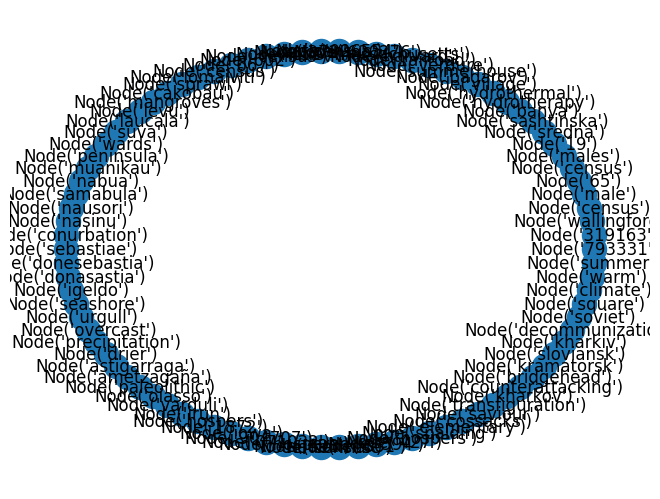

In [23]:
nx.draw_shell(G, with_labels = True)

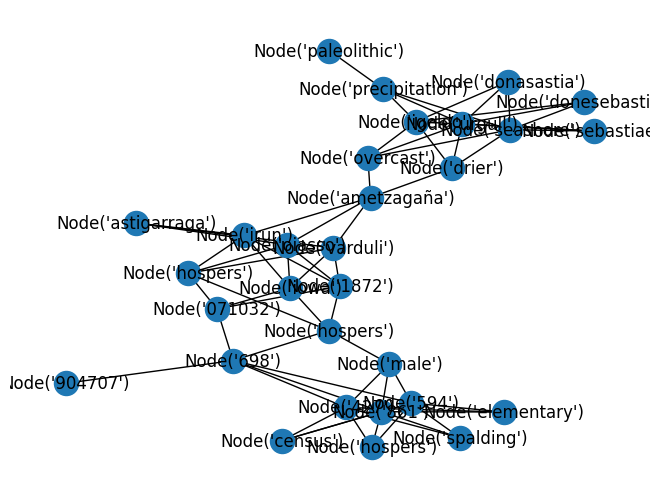

In [20]:
nx.draw_kamada_kawai(G, with_labels = True)

---

### Testing Graph Functionality

In [23]:
nodes = G.get_nodes_at_distance(distance=1)
print([str(n) for n in nodes])

["Node('zurriola')", "Node('haussmannian')", "Node('cortazar')"]


In [24]:
# for n in nodes:
#     print([[str(y) for y in x] for x in G.get_all_paths_to_node(n)])

In [25]:
linear_paths = G.get_linear_paths_to_node(nodes[0])

In [26]:
for path in linear_paths:
    prev_node = None
    for node in path:
        if prev_node is not None:
            print(str(prev_node), "--", G.get_edge(prev_node, node)["weight"], "--> ", end="")
        prev_node = node
    print(str(node))

Node('zurriola') -- tensor([0.7485]) --> Node('alkartasuna') -- tensor([0.7556]) --> Node('berria') -- tensor([0.5859]) --> Node('1265') -- tensor([0.5713]) --> Node('oiasso') -- tensor([0.8044]) --> Node('ametzagaña') -- tensor([0.5119]) --> Node('overcast') -- tensor([0.5847]) --> Node('igeldo') -- tensor([0.6393]) --> Node('sebastiae')
Node('zurriola') -- tensor([0.7485]) --> Node('alkartasuna') -- tensor([0.7556]) --> Node('berria') -- tensor([0.5859]) --> Node('1265') -- tensor([0.5713]) --> Node('oiasso') -- tensor([0.8044]) --> Node('ametzagaña') -- tensor([0.5119]) --> Node('overcast') -- tensor([0.6868]) --> Node('seashore') -- tensor([0.5354]) --> Node('sebastiae')
Node('zurriola') -- tensor([0.7485]) --> Node('alkartasuna') -- tensor([0.7556]) --> Node('berria') -- tensor([0.5859]) --> Node('1265') -- tensor([0.5713]) --> Node('oiasso') -- tensor([0.8044]) --> Node('ametzagaña') -- tensor([0.5119]) --> Node('overcast') -- tensor([0.5863]) --> Node('urgull') -- tensor([0.5674

---